In [1]:
import pandas as pd
import numpy as np
import processing_pipeline as pp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy import ndimage 
from sklearn.model_selection import train_test_split
import processing_pipeline as pp

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:matplotlib:matplotlib data path: c:\Users\framo\Google Drive\github\NotHotDog\.conda\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\framo\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\framo\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\framo\.matplotlib\fontlist-v330.json


In [2]:
pipe = pp.preprocess()
df = pipe.rebuild_dataset('../df.h5')

In [3]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

img = np.stack(df[~(df.label == '')].img)

encoder = LabelEncoder().fit(df[~(df.label == '')].label.str.contains("Hot"))
labels = encoder.transform(df[~(df.label == '')].label.str.contains("Hot"))


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    img, labels, test_size=0.33, random_state=42)

In [7]:
X_train.shape

(1884, 250, 250, 3)

### Transfer Learning

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#we can set the input size to be the size of the input image (not necessarily 224x224)
#VGG19(weights='imagenet', input_shape=[32,32,3],include_top=False) 
base_model = ResNet50(weights='imagenet',input_shape=[250,250,3],include_top=False)

feature_model = Model(inputs= base_model.input, outputs=base_model.output )

train_images_sub = preprocess_input(X_train)
test_images_sub = preprocess_input(X_test)
train_features = feature_model.predict(train_images_sub)
test_features = feature_model.predict(test_images_sub)

DEBUG:h5py._conv:Creating converter from 3 to 5


29/29 [==============================] - 100s 3s/step


In [13]:
train_features.shape

(1884, 8, 8, 2048)

In [14]:
model4 = keras.Sequential(
    [
        layers.Input((8, 8, 2048)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(2, activation='softmax')
    ], 
)

opt = keras.optimizers.Adam(learning_rate=0.001)
model4.compile(optimizer=opt,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

cls4=model4.fit(train_features, y_train, validation_data=(test_features, y_test),epochs=30, batch_size=32)

Epoch 1/30
59/59 [==============================] - 48s 716ms/step - loss: 3.6623 - accuracy: 0.5255 - val_loss: 1.0284 - val_accuracy: 0.6304
Epoch 2/30
59/59 [==============================] - 40s 686ms/step - loss: 0.6938 - accuracy: 0.6672 - val_loss: 0.7724 - val_accuracy: 0.6379
Epoch 3/30
59/59 [==============================] - 44s 746ms/step - loss: 0.6174 - accuracy: 0.6847 - val_loss: 0.6272 - val_accuracy: 0.6961
Epoch 4/30
59/59 [==============================] - 47s 802ms/step - loss: 0.5483 - accuracy: 0.7378 - val_loss: 0.9336 - val_accuracy: 0.6455
Epoch 5/30
59/59 [==============================] - 47s 805ms/step - loss: 0.7277 - accuracy: 0.7102 - val_loss: 1.0648 - val_accuracy: 0.6369
Epoch 6/30
59/59 [==============================] - 48s 823ms/step - loss: 0.7872 - accuracy: 0.6789 - val_loss: 1.2006 - val_accuracy: 0.5151
Epoch 7/30
59/59 [==============================] - 47s 803ms/step - loss: 0.4806 - accuracy: 0.7771 - val_loss: 0.6602 - val_accuracy: 0.7091

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\framo\\Google Drive\\github\\NotHotDog\\.conda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\framo\\Google Drive\\github\\NotHotDog\\.conda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEn

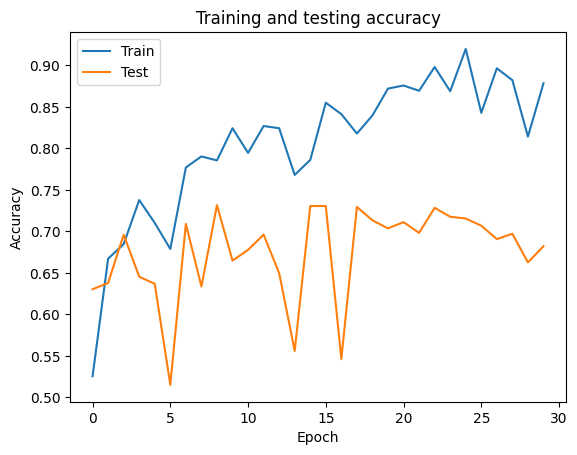

In [15]:
plt.plot(cls4.history['accuracy'], label='Train')
plt.plot(cls4.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and testing accuracy')
plt.legend()
plt.show()

In [16]:
# Majority class only
np.unique(labels, return_counts=True)
3526/(3526+1104)


0.7615550755939525

In [18]:
from sklearn.metrics import classification_report
predictions = model4.predict(test_features)
pred = predictions.argmax(axis=1)
print(classification_report(y_test, pred))

29/29 [==============================] - 2s 46ms/step
              precision    recall  f1-score   support

           0       0.82      0.61      0.70       564
           1       0.57      0.79      0.66       364

    accuracy                           0.68       928
   macro avg       0.69      0.70      0.68       928
weighted avg       0.72      0.68      0.69       928



In [73]:
encoder.classes_

array([False,  True])

### Color histogram

In [5]:
img[0].shape

(250, 250, 3)

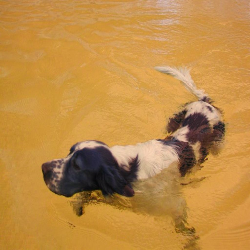

In [10]:
from PIL import Image
Image.fromarray((img[0]*255).astype(np.uint8))

In [11]:
import cv2
for i in img[:1]:
    cv2.imshow('image',(i * 255).astype(np.uint8))

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [12]:
import cv2

colorVect = []
binSize = 32
for im in img:
    im = (im * 255).astype(np.uint8)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([im], [0, 1, 2], None, [binSize, binSize, binSize],
            [0, 256, 0, 256, 0, 256])
    vect = cv2.normalize(hist, hist).flatten()
    colorVect.append(vect)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    colorVect, labels, test_size=0.33, random_state=42)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       564
           1       0.75      0.55      0.63       364

    accuracy                           0.75       928
   macro avg       0.75      0.72      0.72       928
weighted avg       0.75      0.75      0.74       928



In [19]:
from sklearn.svm import LinearSVC

clf = LinearSVC( random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       564
           1       0.78      0.75      0.77       364

    accuracy                           0.82       928
   macro avg       0.81      0.81      0.81       928
weighted avg       0.82      0.82      0.82       928



In [20]:
from sklearn.svm import SVC

clf = SVC(gamma='auto',random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       564
           1       0.00      0.00      0.00       364

    accuracy                           0.61       928
   macro avg       0.30      0.50      0.38       928
weighted avg       0.37      0.61      0.46       928



c:\Users\framo\Google Drive\github\NotHotDog\.conda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\framo\Google Drive\github\NotHotDog\.conda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\framo\Google Drive\github\NotHotDog\.conda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [21]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       564
           1       0.77      0.94      0.85       364

    accuracy                           0.87       928
   macro avg       0.86      0.88      0.87       928
weighted avg       0.88      0.87      0.87       928



In [22]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(force_alpha=True).fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       564
           1       0.69      0.72      0.70       364

    accuracy                           0.76       928
   macro avg       0.75      0.75      0.75       928
weighted avg       0.76      0.76      0.76       928

